In [1]:
import warnings
from preprocess import remove_nan_rows_xy, remove_collinear_variables, preprocess_algerian_forest_fires, \
    preprocess_waveform_database_generator_version_1
from data.dataset import get_dataset
from model.logistic_regression import LogisticRegression as LogReg
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
def plot(df):
    fig, axes = plt.subplots(nrows=len(df), ncols=1, figsize=(10, 15))
    for i, (dataset_name, balanced_accuracy) in enumerate(df.items()):
        df = pd.DataFrame(balanced_accuracy)
        sns.boxplot(data=df, ax=axes[i])
        axes[i].set_title(f'Dataset: {dataset_name}')
        axes[i].set_ylabel('Balanced Accuracy')
    
    plt.tight_layout()
    plt.show()

In [20]:
def plot2(df):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 15))
    datasets = list(df.items())
    
    for i in range(3):
        for j in range(3):
            dataset_name, balanced_accuracy = datasets[i*3 + j]
            df_balanced_accuracy = pd.DataFrame(balanced_accuracy)
            sns.boxplot(data=df_balanced_accuracy, ax=axes[i, j])
            axes[i, j].set_title(f'Dataset: {dataset_name}')
            axes[i, j].set_ylabel('Balanced Accuracy')
    
    plt.tight_layout()
    plt.show()

In [4]:
SEED = 0
sns.set_style("whitegrid")
optimizers = ['sgd', 'adam', 'iwls']
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier()
}
# datasets = ["banknote_authentication", "connectionist_bench_sonar_mines_vs_rocks", "ionosphere", "fertility ", "algerian_forest_fires"]
datasets = ["banknote_authentication", "spambase", "taiwanese_bankruptcy_prediction",
            "connectionist_bench_sonar_mines_vs_rocks", "ionosphere", "magic_gamma_telescope", "fertility ", "algerian_forest_fires", "waveform_database_generator_version_1"]

## Datasets preparation

In [5]:
loaded_datasets = {}
for ds in datasets:
    print(f"\nDataset: {ds}")
    X, y = get_dataset(ds)
    X, y = remove_nan_rows_xy(X, y)
    
    if ds == "waveform_database_generator_version_1":
        X, y = preprocess_waveform_database_generator_version_1(X, y)
    
    if ds == "algerian_forest_fires":
        X, y = preprocess_algerian_forest_fires(X, y)
    
    hc, X_ = remove_collinear_variables(X, 0.9)
    if hc > 0:
        X = X_
        print(f"Highly correlated variables present, deleted columns: {hc}")
    
    loaded_datasets[ds] = (X, y) 


Dataset: banknote_authentication
Number of rows removed: 0

Dataset: spambase
Number of rows removed: 0
Highly correlated variables present, deleted columns: 1

Dataset: taiwanese_bankruptcy_prediction
Number of rows removed: 0
Highly correlated variables present, deleted columns: 19

Dataset: connectionist_bench_sonar_mines_vs_rocks
Number of rows removed: 0
Highly correlated variables present, deleted columns: 3

Dataset: ionosphere
Number of rows removed: 0

Dataset: magic_gamma_telescope
Number of rows removed: 0
Highly correlated variables present, deleted columns: 1

Dataset: fertility 
Number of rows removed: 0

Dataset: algerian_forest_fires
Number of rows removed: 1
Highly correlated variables present, deleted columns: 2

Dataset: waveform_database_generator_version_1
Number of rows removed: 0


## 3.2 Computing balanced accuracy for all 3 optimizers

In [6]:
np.random.seed(SEED)
results = {}
for ds in loaded_datasets:
    print(f"\nDataset: {ds}")
    X = loaded_datasets[ds][0]
    y = loaded_datasets[ds][1]
    balanced_accuracy = {'SGD': [], 'ADAM': [], 'IWLS': []}
    
    kfold = KFold(5, shuffle=True)
    for train, test in kfold.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        for opt in optimizers:
            clf = LogReg(num_iterations=500, learning_rate=0.001, optimizer=opt, batch_size=1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            balanced_accuracy[opt.upper()].append(balanced_accuracy_score(y_pred, y_test))
        
    results[ds] = balanced_accuracy


Dataset: banknote_authentication
Convergence reached, iteration number: 23
Convergence reached, iteration number: 36
Convergence reached, iteration number: 40
Convergence reached, iteration number: 26
Convergence reached, iteration number: 29
Convergence reached, iteration number: 15
Convergence reached, iteration number: 35
Convergence reached, iteration number: 68
Convergence reached, iteration number: 16
Convergence reached, iteration number: 25
Convergence reached, iteration number: 34
Convergence reached, iteration number: 26
Convergence reached, iteration number: 30
Convergence reached, iteration number: 22

Dataset: spambase
Convergence reached, iteration number: 33
Convergence reached, iteration number: 98
Convergence reached, iteration number: 456
Convergence reached, iteration number: 10
Convergence reached, iteration number: 114
Convergence reached, iteration number: 408

Dataset: taiwanese_bankruptcy_prediction
Convergence reached, iteration number: 126
Convergence reached

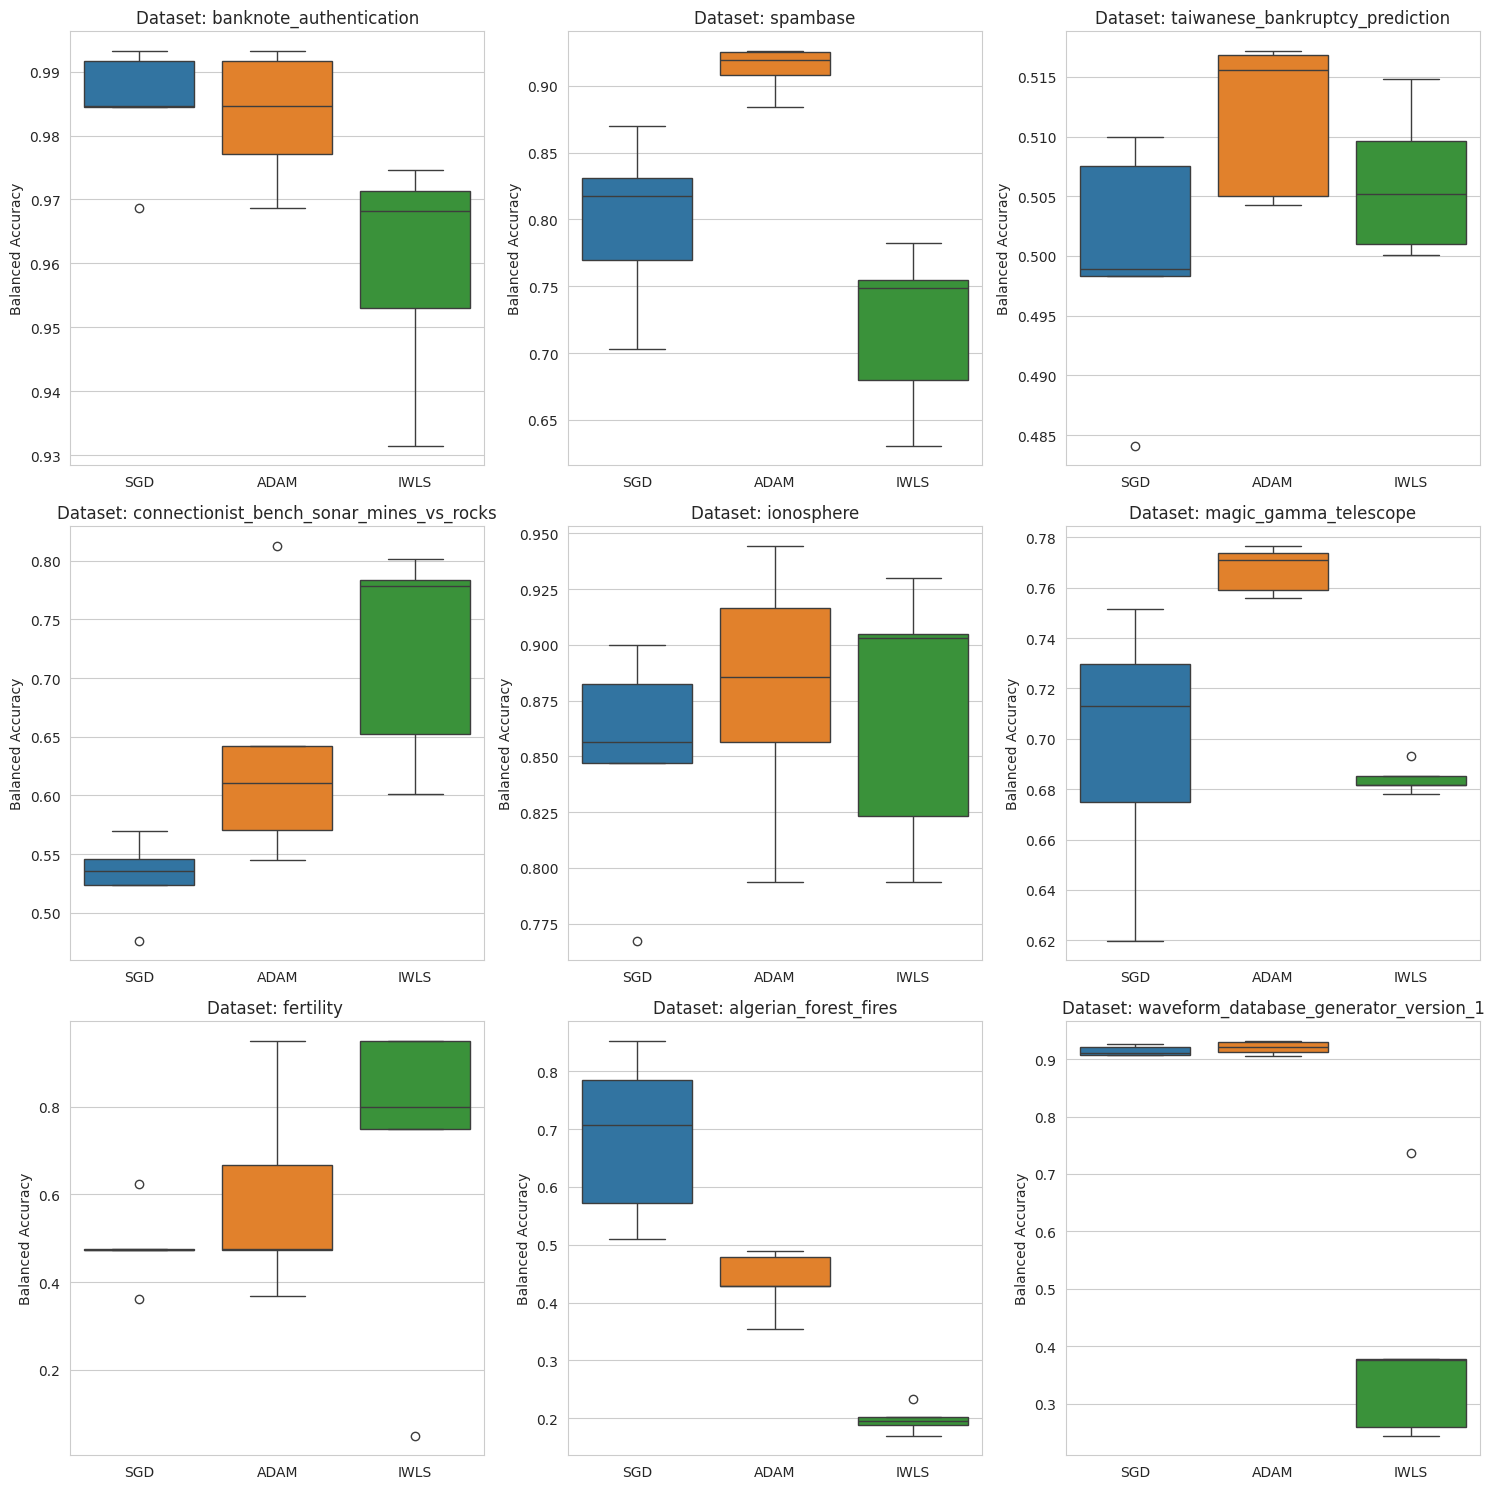

In [7]:
plot2(results)

## Experiment with scaling

In [8]:
np.random.seed(SEED)
results_scaling = {}
for ds in loaded_datasets:
    print(f"\nDataset: {ds}")
    X = loaded_datasets[ds][0]
    y = loaded_datasets[ds][1]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    
    balanced_accuracy = {'SGD - scaled': [], 'ADAM - scaled': [], 'IWLS - scaled': []}
    kfold = KFold(5, shuffle=True)
    for train, test in kfold.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        for opt in optimizers:
            clf = LogReg(num_iterations=500, learning_rate=0.001, optimizer=opt, batch_size=1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            balanced_accuracy[f"{opt.upper()} - scaled"].append(balanced_accuracy_score(y_pred, y_test))
        
    results_scaling[ds] = balanced_accuracy


Dataset: banknote_authentication
Convergence reached, iteration number: 48
Convergence reached, iteration number: 48
Convergence reached, iteration number: 15
Convergence reached, iteration number: 60
Convergence reached, iteration number: 43
Convergence reached, iteration number: 13
Convergence reached, iteration number: 61
Convergence reached, iteration number: 40
Convergence reached, iteration number: 13
Convergence reached, iteration number: 66
Convergence reached, iteration number: 40
Convergence reached, iteration number: 15
Convergence reached, iteration number: 50
Convergence reached, iteration number: 34
Convergence reached, iteration number: 46

Dataset: spambase
Convergence reached, iteration number: 98
Convergence reached, iteration number: 35
Convergence reached, iteration number: 79
Convergence reached, iteration number: 143
Convergence reached, iteration number: 59
Convergence reached, iteration number: 203
Convergence reached, iteration number: 58
Convergence reached, 

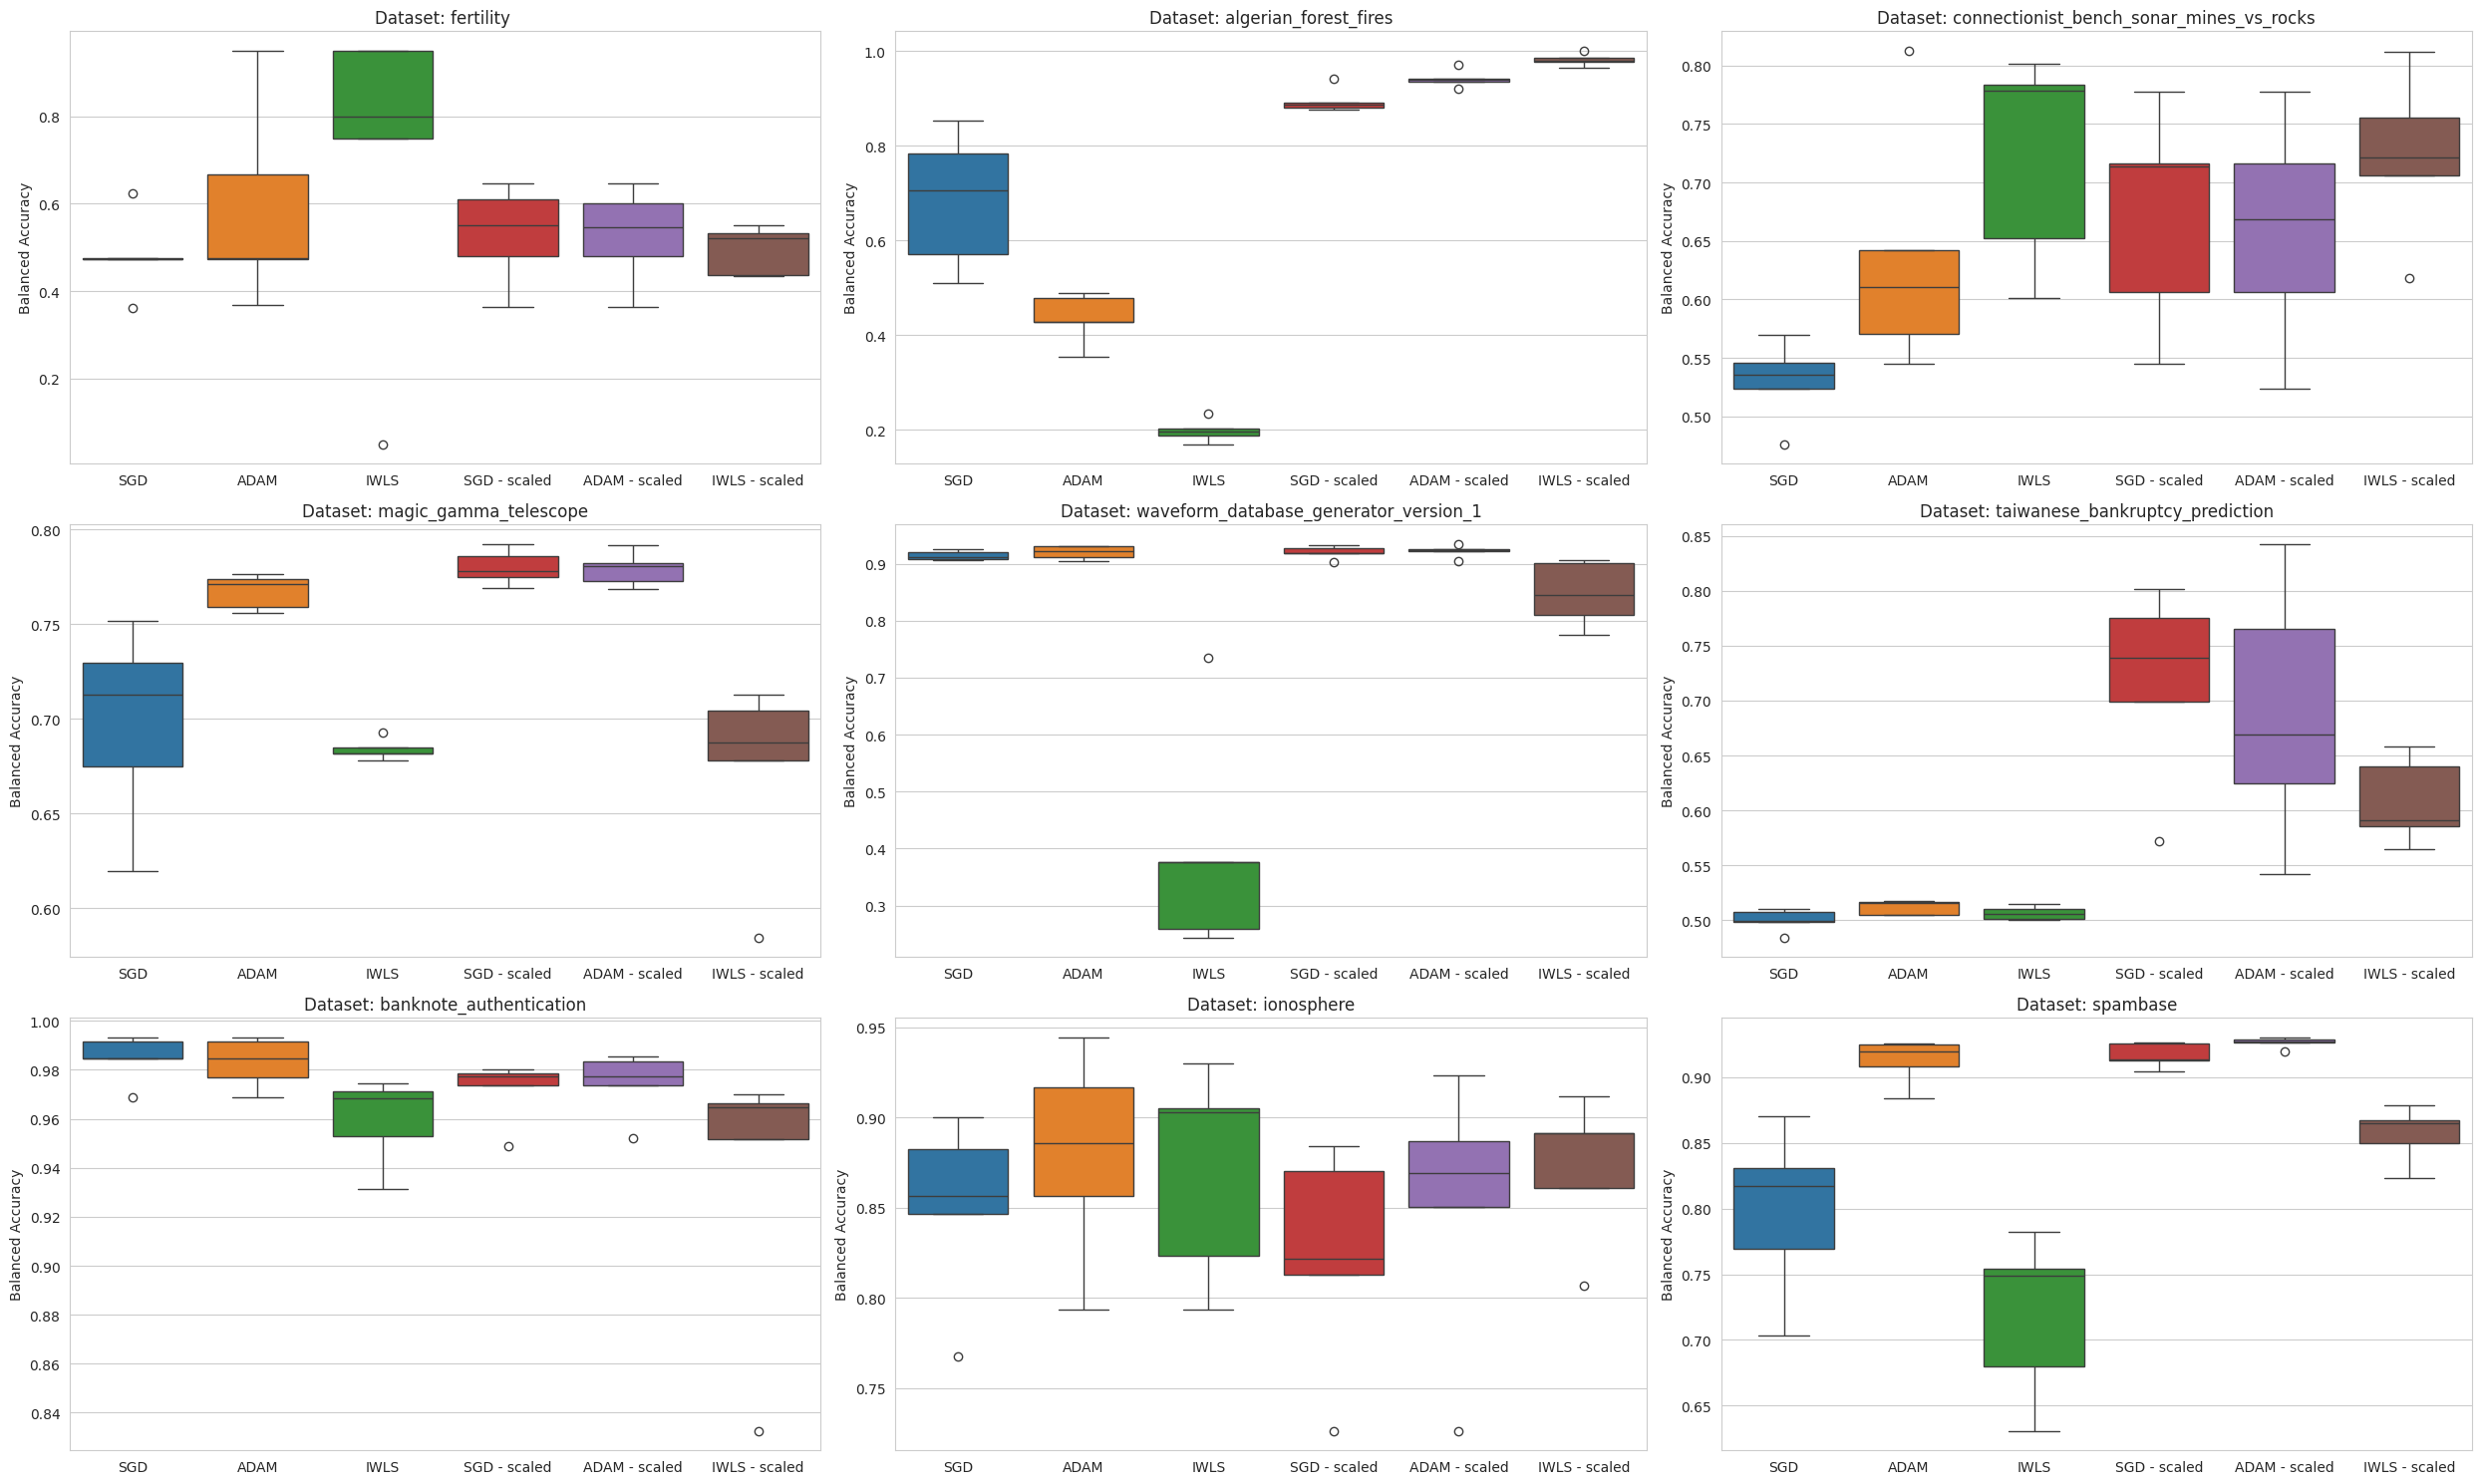

In [21]:
scaled_not_scaled = {key: {**results.get(key, {}), **results_scaling.get(key, {})} for key in set(results) | set(results_scaling)}
plot2(scaled_not_scaled)

## 3.3 Convergence analysis


Dataset: banknote_authentication
Convergence reached, iteration number: 14
Convergence reached, iteration number: 31
Convergence reached, iteration number: 40

Dataset: spambase
Convergence reached, iteration number: 220
Convergence reached, iteration number: 290

Dataset: taiwanese_bankruptcy_prediction
Convergence reached, iteration number: 91

Dataset: connectionist_bench_sonar_mines_vs_rocks
Convergence reached, iteration number: 13
Convergence reached, iteration number: 44
Convergence reached, iteration number: 392

Dataset: ionosphere
Convergence reached, iteration number: 49
Convergence reached, iteration number: 56
Convergence reached, iteration number: 40

Dataset: magic_gamma_telescope
Convergence reached, iteration number: 119
Convergence reached, iteration number: 330
Convergence reached, iteration number: 87

Dataset: fertility 
Convergence reached, iteration number: 45
Convergence reached, iteration number: 43
Convergence reached, iteration number: 7

Dataset: algerian_f

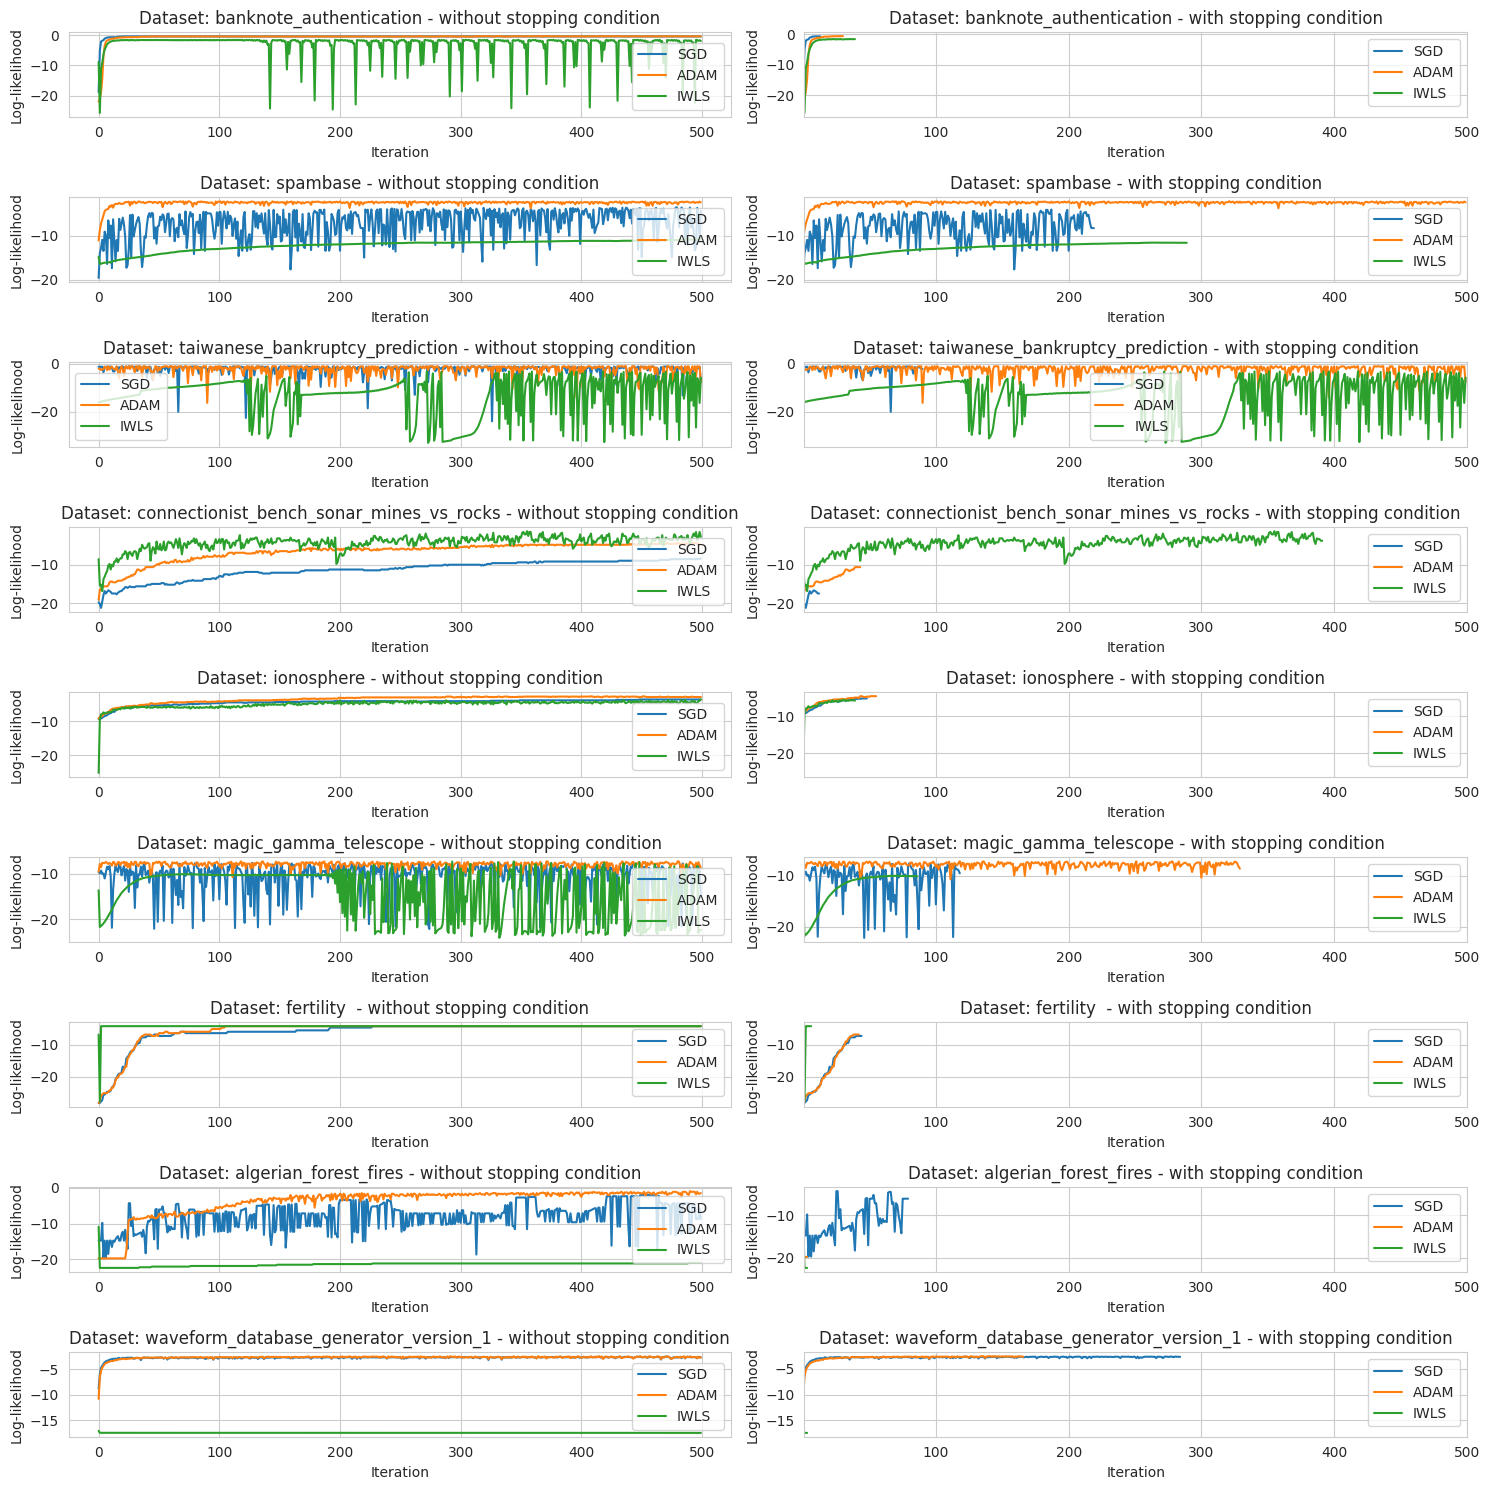

In [10]:
np.random.seed(SEED)
fig, axs = plt.subplots(len(loaded_datasets), 2, figsize=(15, 15))
for i, ds in enumerate(loaded_datasets):
    print(f"\nDataset: {ds}")
    X = loaded_datasets[ds][0]
    y = loaded_datasets[ds][1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    for j, opt in enumerate(optimizers):  
        clf_no_stop = LogReg(num_iterations=500, learning_rate=0.001, optimizer=opt, batch_size=1, stop_after=None)
        clf_no_stop.fit(X_train, y_train)
        axs[i, 0].plot(clf_no_stop.losses, label=f"{opt.upper()}")

        clf_stop = LogReg(num_iterations=500, learning_rate=0.001, optimizer=opt, batch_size=1)
        clf_stop.fit(X_train, y_train)
        axs[i, 1].plot(clf_stop.losses, label=f"{opt.upper()}")

        axs[i, 0].set_title(f"Dataset: {ds} - without stopping condition")
        axs[i, 1].set_title(f"Dataset: {ds} - with stopping condition")

for ax in axs.flat:
    ax.set(xlabel="Iteration", ylabel="Log-likelihood")
    ax.legend()
    
for ax in axs[:, 1].flat:
    ax.set_xlim(1, 500)
    
plt.tight_layout()
plt.show()

## 3.4 Compare the classification performance of logistic regression and 4 popular classification methods 

In [11]:
np.random.seed(SEED)
new_results = {}
for ds in loaded_datasets:
    X = loaded_datasets[ds][0]
    y = loaded_datasets[ds][1]
    balanced_accuracy = {'LDA': [], 'QDA': [], 'DT': [], 'RF': []}
    
    kfold = KFold(5, shuffle=True)
    for train, test in kfold.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        for clf_name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
    
            balanced_accuracy[clf_name].append(balanced_accuracy_score(y_pred, y_test))
        
    new_results[ds] = balanced_accuracy

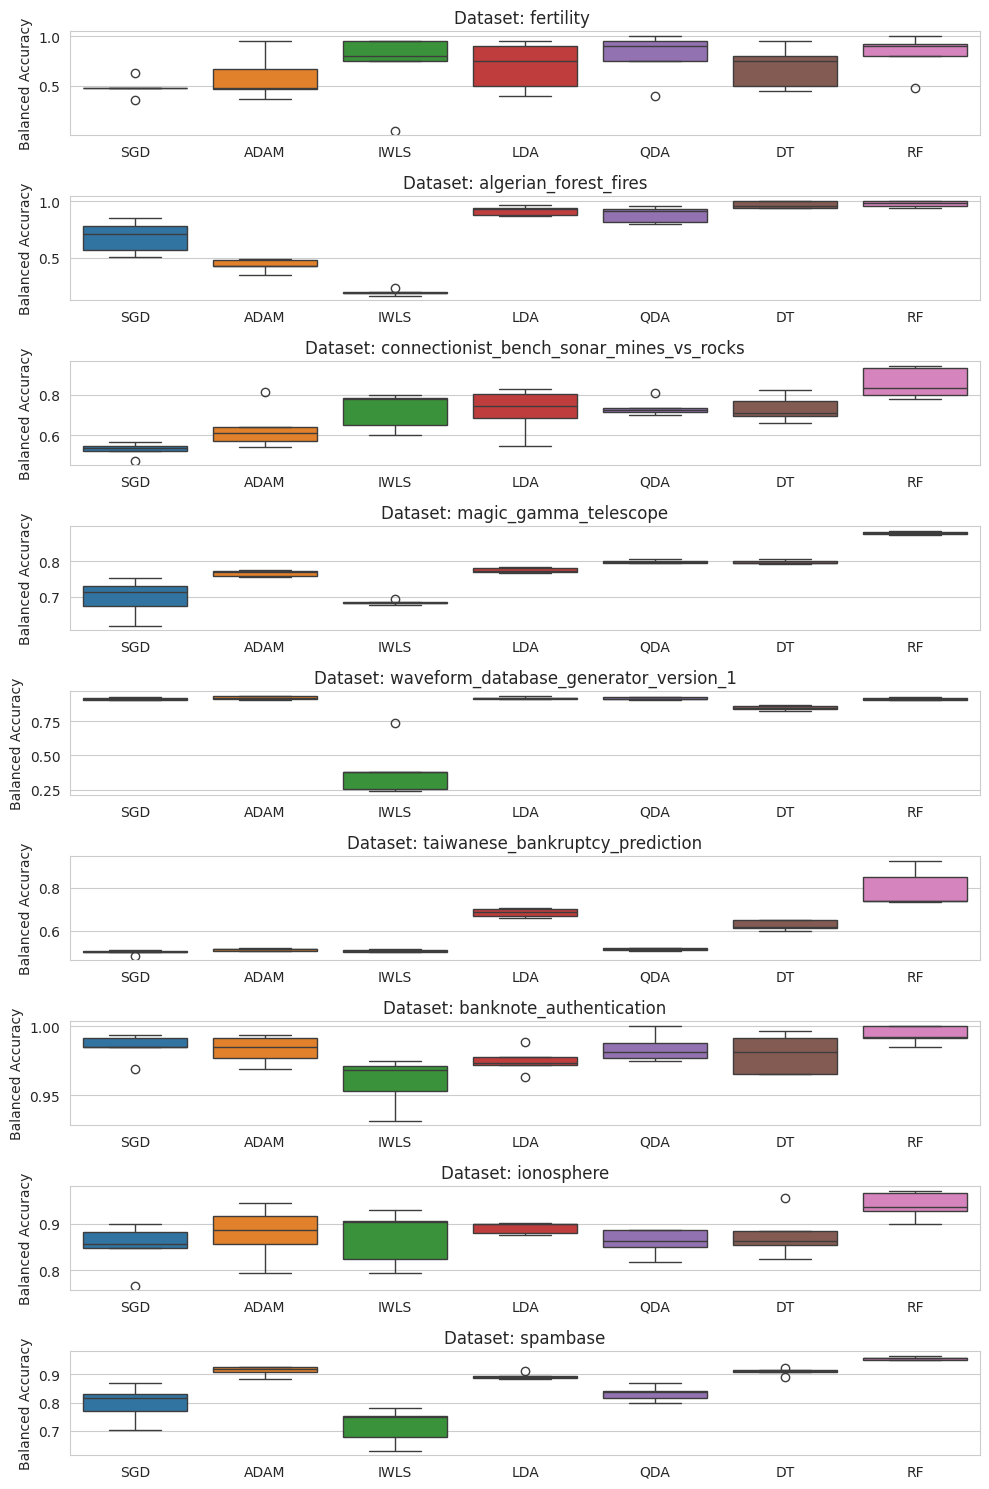

In [23]:
all_results = {key: {**results.get(key, {}), **new_results.get(key, {})} for key in set(results) | set(new_results)}
plot(all_results)

### 3.5 Compare the two versions of the logistic regression: model without interactions and model with interactions

In [13]:
np.random.seed(SEED)
results_interactions = {}
for ds in loaded_datasets:
    X = loaded_datasets[ds][0]
    # Only small datasets
    if X.shape[1] >= 10:
        continue
    y = loaded_datasets[ds][1]
    balanced_accuracy = {'SGD - interactions': [], 'ADAM - interactions': [], 'IWLS - interactions': []}
    
    kfold = KFold(5, shuffle=True)
    for train, test in kfold.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        for opt in optimizers:
            clf = LogReg(num_iterations=500, learning_rate=0.001, optimizer=opt, batch_size=1, interactions=True)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            balanced_accuracy[f"{opt.upper()} - interactions"].append(balanced_accuracy_score(y_pred, y_test))
        
    results_interactions[ds] = balanced_accuracy

Convergence reached, iteration number: 24
Convergence reached, iteration number: 30
Convergence reached, iteration number: 222
Convergence reached, iteration number: 23
Convergence reached, iteration number: 36
Convergence reached, iteration number: 144
Convergence reached, iteration number: 48
Convergence reached, iteration number: 36
Convergence reached, iteration number: 160
Convergence reached, iteration number: 42
Convergence reached, iteration number: 39
Convergence reached, iteration number: 74
Convergence reached, iteration number: 40
Convergence reached, iteration number: 36
Convergence reached, iteration number: 93
Convergence reached, iteration number: 65
Convergence reached, iteration number: 391
Convergence reached, iteration number: 35
Convergence reached, iteration number: 32
Convergence reached, iteration number: 30
Convergence reached, iteration number: 18
Convergence reached, iteration number: 31
Convergence reached, iteration number: 11
Convergence reached, iteration

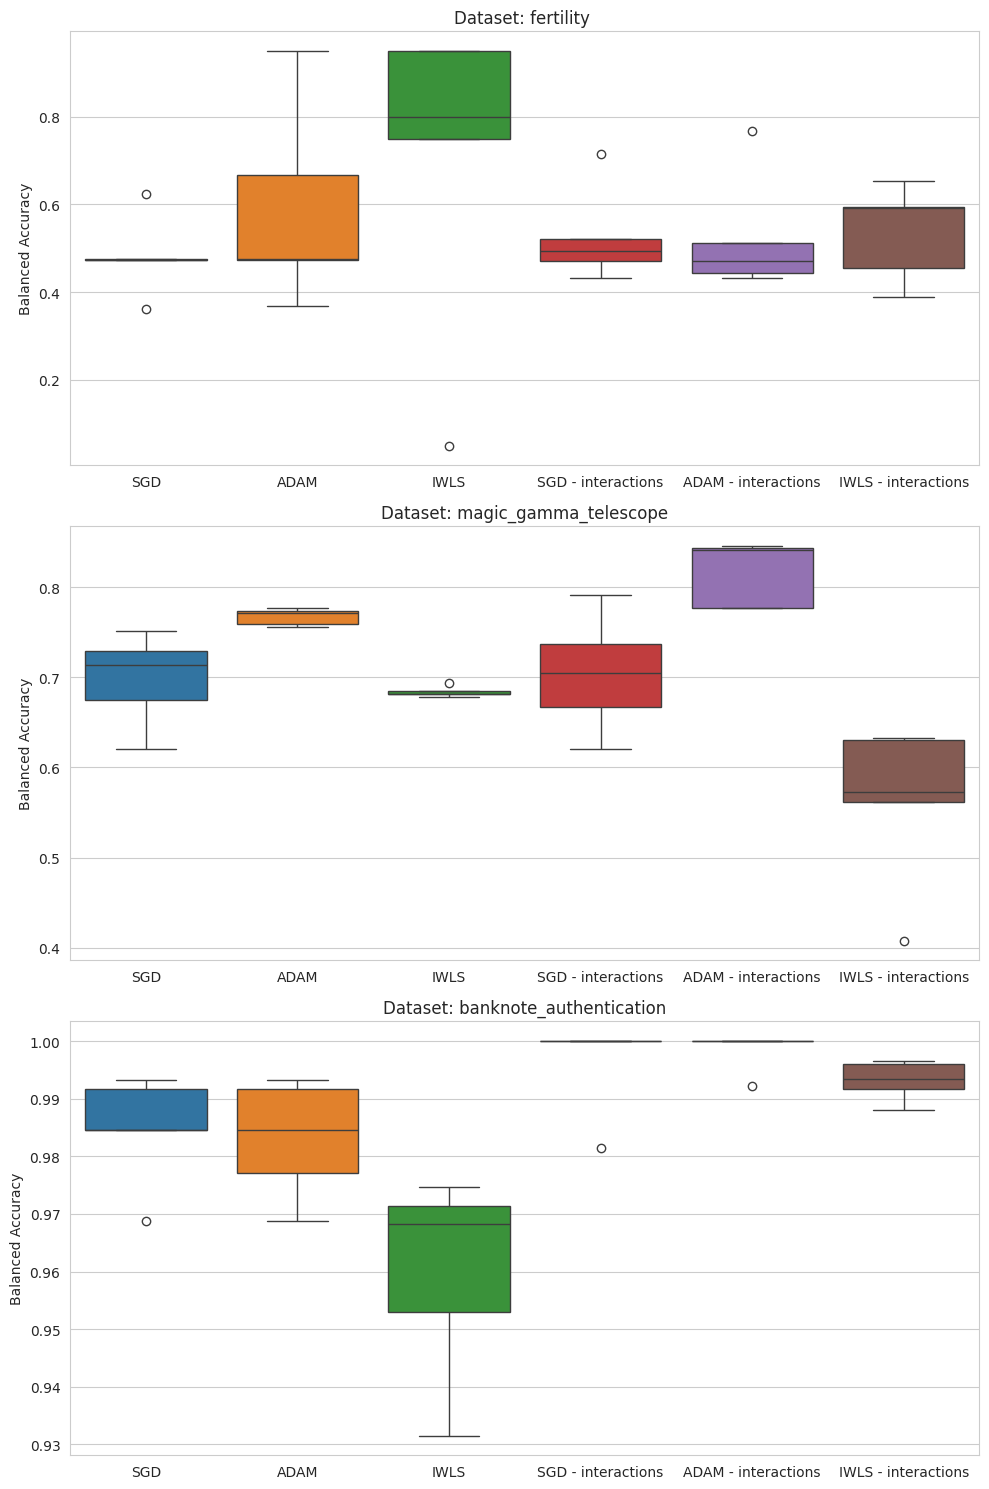

In [14]:
interaction_compare = {key: {**results.get(key, {}), **results_interactions.get(key, {})} for key in set(results_interactions)}
plot(interaction_compare)